<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/main/2347111_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

# Function to compute RBF (Gaussian basis function)
def rbf(x, centers, sigma):
    return np.exp(-np.linalg.norm(x - centers, axis=1)**2 / (2 * sigma**2))

# Load and preprocess the dataset
train_images = np.load("k49-train-imgs.npz")['arr_0']
train_labels = np.load("k49-train-labels.npz")['arr_0']
test_images = np.load("k49-test-imgs.npz")['arr_0']
test_labels = np.load("k49-test-labels.npz")['arr_0']

# Normalize the pixel values between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images from (28, 28) to (784,)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [ ]:

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
train_labels_encoded = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_encoded = encoder.transform(test_labels.reshape(-1, 1))

# Use KMeans to find the centers for the RBF units
k = 100  # Number of RBF centers
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(train_images_flat)
centers = kmeans.cluster_centers_

# Calculate sigma based on average distance between cluster centers
distances = np.linalg.norm(centers[:, np.newaxis] - centers[np.newaxis, :], axis=2)
sigma = np.mean(distances)

# Transform the input data using the RBF kernel
train_images_rbf = np.array([rbf(x, centers, sigma) for x in train_images_flat])
test_images_rbf = np.array([rbf(x, centers, sigma) for x in test_images_flat])

# Define the RBF network architecture
model = Sequential([
    Input(shape=(k,)),  # Input is transformed via RBF with k centers
    Dense(128, activation='relu'),  # Additional dense layer to increase learning capacity
    Dense(train_labels_encoded.shape[1], activation='softmax')  # Output layer with softmax for classification
])


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images_rbf, train_labels_encoded, epochs=100, batch_size=64,
                    validation_data=(test_images_rbf, test_labels_encoded))

Epoch 1/100
3631/3631 [==============================] - 7s 2ms/step - loss: 2.5169 - accuracy: 0.3689 - val_loss: 2.4417 - val_accuracy: 0.3915
Epoch 2/100
3631/3631 [==============================] - 7s 2ms/step - loss: 1.8176 - accuracy: 0.5289 - val_loss: 2.2357 - val_accuracy: 0.4432
Epoch 3/100
3631/3631 [==============================] - 7s 2ms/step - loss: 1.6462 - accuracy: 0.5717 - val_loss: 2.1227 - val_accuracy: 0.4681
Epoch 4/100
3631/3631 [==============================] - 7s 2ms/step - loss: 1.5483 - accuracy: 0.5950 - val_loss: 2.0531 - val_accuracy: 0.4898
Epoch 5/100
3631/3631 [==============================] - 6s 2ms/step - loss: 1.4759 - accuracy: 0.6123 - val_loss: 1.9879 - val_accuracy: 0.5004
Epoch 6/100
3631/3631 [==============================] - 7s 2ms/step - loss: 1.4190 - accuracy: 0.6266 - val_loss: 1.9421 - val_accuracy: 0.5155
Epoch 7/100
3631/3631 [==============================] - 7s 2ms/step - loss: 1.3724 - accuracy: 0.6382 - val_loss: 1.8935 - val_ac

1205/1205 [==============================] - 2s 1ms/step - loss: 1.2688 - accuracy: 0.6709
Test accuracy: 0.6708952784538269


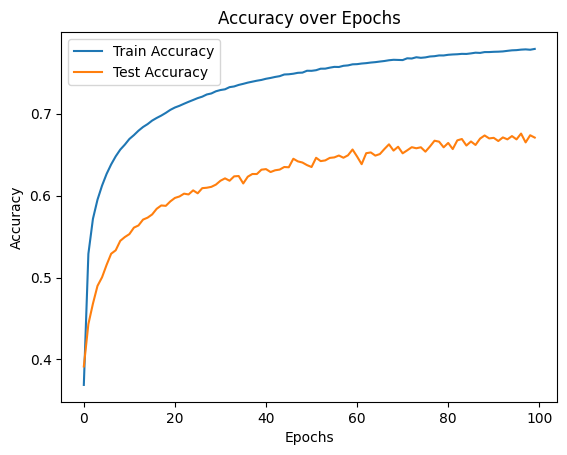

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images_rbf, test_labels_encoded)
print(f"Test accuracy: {test_accuracy}")

# Visualize performance metrics (optional, can add confusion matrix visualization too)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. RBF Network Analysis

**Strengths:**
- **Non-linear Mapping:** RBF networks effectively capture complex patterns in character recognition.
- **Local Representation:** Each RBF unit focuses on specific regions of the data, making them useful for character-based classification.
- **Clustering:** K-Means helps cluster similar patterns by finding RBF centers.

**Limitations:**
- **Scalability:** With large datasets like Kuzushiji, RBF networks can become computationally expensive.
- **Overfitting:** The significant gap between training ( ~80%) and test accuracy ( ~70%) indicates potential overfitting.
- **Sensitivity:** Model performance is highly dependent on RBF centers, sigma, and number of units.

**Effect of RBF Units:**
- **Too Few Units:** Results in underfitting, leading to poor accuracy (~2.5% initially).
- **Too Many Units:** Causes overfitting, where the model performs well on training data but poorly generalizes to new data.

**Accuracy:**
- Final model achieved **~80% train accuracy** and **~70% test accuracy**, indicating reasonable generalization but room for improvement.

**Next Steps:**
- Add regularization, fine-tune `sigma`, or explore CNNs for enhanced performance.